# Домашнее задание к лекции «Деревья решений»

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

Используя знания из предыдущего домашнего задания, я буду использовать для обучения LSTAT, RM и PTRATIO, а также удалю из дата-сета дома с целевой переменной равной 50.0

In [79]:
data = pd.read_csv(load_boston()['filename'], skiprows=1)

data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [82]:
df = data[data.MEDV < 50]

df.shape

(490, 14)

In [112]:
# Вспомогательные функции

def fit_model(X, y, random_seed=42, model='tree', print_res=True, criterion='mse', max_depth=None, min_samples_split=2, 
                   min_samples_leaf=1, max_features=None, splitter='best' ):
    
    if model == 'regression':
        model = LinearRegression()
        
    if model == 'tree':
        model = DecisionTreeRegressor(random_state=random_seed, criterion=criterion, max_depth=max_depth, 
                                      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                      max_features=max_features, splitter=splitter)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed )  
    model.fit(X_train, y_train)
    pred_values_train = model.predict(X_train)
    pred_values_test = model.predict(X_test)
    
    if print_res:    
        print('TRAIN')
        print('Error RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, pred_values_train))))    
        print('Score: {}'.format(model.score(X_train, y_train)))   
        print()
        print('TEST')
        print('Error RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, pred_values_test))))    
        print('Score: {}'.format(model.score(X_test, y_test)))  
        
    return np.sqrt(mean_squared_error(y_test, pred_values_test)), model.score(X_test, y_test)    

In [83]:
X = df[['LSTAT', 'RM', 'PTRATIO']]
y = df.MEDV

Строим модель линейной регрессии:

In [85]:
fit_model(X, y, model='regression')

TRAIN
Error RMSE: 4.333712782945438
Score: 0.7103401721175919

TEST
Error RMSE: 3.929894049140974
Score: 0.7058701162343138


(3.929894049140974, 0.7058701162343138)

Теперь строим дерево решений с параметрами по умолчанию (без ограничений на глубину дерева и др.):

In [86]:
fit_model(X, y)

TRAIN
Error RMSE: 0.0
Score: 1.0

TEST
Error RMSE: 3.9766751914421286
Score: 0.6988258401571857


(3.9766751914421286, 0.6988258401571857)

Пока результаты примерно равны. Попробуем подобрать параметры для дерева решений. Для этого я просто в цикле перебираю варианты и смотрю, что даст наилучший результат.

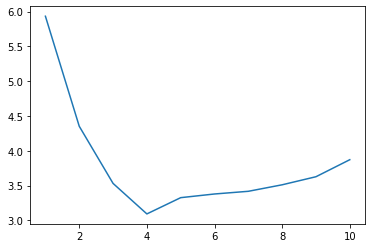

In [103]:
# max_depth
max_depth = []

for i in range(1, 11):
    error, score = fit_model(X, y, print_res=False, max_depth=i)
    max_depth.append(error)    
    
plt.plot(range(1, 11), max_depth)

На графике видно изменение RMSE в зависимости от максимальной глубины дерева. Наименьшая ошибка достигается при max_depth=4

In [104]:
fit_model(X, y, max_depth=4)

TRAIN
Error RMSE: 2.9330657402145133
Score: 0.8673181212333694

TEST
Error RMSE: 3.0916203761550487
Score: 0.8179671412512007


(3.0916203761550487, 0.8179671412512007)

Качество заметно выросло. Попробуем ещё немного поперебирать параметры:

In [105]:
# criterion
criterion = ['mse', 'friedman_mse', 'mae']


for i, crit_value in enumerate(criterion):
    error, score = fit_model(X, y, print_res=False, max_depth=4, criterion=crit_value)
    print(crit_value, error)  

mse 3.0916203761550487
friedman_mse 3.0916203761550487
mae 3.1858290604991804


Оставляем criterion='mse' по умолчанию

In [116]:
# splitter
splitter = ['best', 'random']

for i, splitter_value in enumerate(splitter):
    error, score = fit_model(X, y, print_res=False, max_depth=4, splitter=splitter_value)
    print(splitter_value, error)  

best 3.0916203761550487
random 4.027161433513362


In [ ]:
Оставляем best='best' по умолчанию

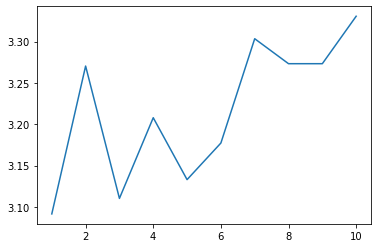

In [117]:
# min_samples_leaf
min_samples_leaf = []

for i in range(1, 11):
    error, score = fit_model(X, y, print_res=False, max_depth=4, min_samples_leaf=i)
    min_samples_leaf.append(error)    
    
plt.plot(range(1, 11), min_samples_leaf)

По этим данным можно предположить, что после того, как мы нашли max_depth=4, можно остановиться, перебор других параметров DecisionTreeRegressor не улучшает качество модели.

##### Вывод

На этом дата-сете дерево решений при правильно подобранной глубине показывает лучшее качество, чем линейная регрессия. 